In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Simonenko
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [54]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [55]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [56]:
hotels.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1472
lng                                             1472
dtype: int64

In [57]:
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [58]:
# создаем признак Location и словарь с координатами
# функция для заполнения сред. значением координаты для региона,города по словарю
def fill_loc(info_hotel):
    global dict_loc
    if np.isnan(info_hotel.lat):
        info_hotel.lat = dict_loc[info_hotel.location]['lat']
    if np.isnan(info_hotel.lng):
        info_hotel.lng = dict_loc[info_hotel.location]['lng']
    return info_hotel


hotels['location'] = hotels['hotel_address'].apply(lambda x : ' '.join(x.split()[-2:]))
dict_loc = hotels.groupby('location')['lat','lng'].mean().to_dict('index')
dict_loc

{'Amsterdam Netherlands': {'lat': 52.36220931379342, 'lng': 4.885346477147374},
 'Barcelona Spain': {'lat': 41.389124787005535, 'lng': 2.169152480241478},
 'Milan Italy': {'lat': 45.479618509909265, 'lng': 9.191844304777105},
 'Paris France': {'lat': 48.8636579645685, 'lng': 2.3268162333003977},
 'United Kingdom': {'lat': 51.51073725346285, 'lng': -0.13907466579527783},
 'Vienna Austria': {'lat': 48.20336764322495, 'lng': 16.367175771189494}}

In [59]:
# удаляем дубли и переводим дату в datetime затем в Int
# переводим hotels['days_since_review'] в int
#hotels = hotels.drop_duplicates(subset=hotels.columns)
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'] = hotels['review_date'].apply(lambda x: int(x.strftime('%Y%m')))

In [60]:
# заполняем пустые значения координат значениями из словаря
hotels = hotels.apply(fill_loc, axis = 1)
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
location                                      0
dtype: int64

In [61]:
# функция смотреть распределение признака и разброс
def g_function(data,feature):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(data[feature], kde=True, ax=axes[0])
    axes[0].set(xlabel=feature, ylabel='Частота')
    axes[0].set_title('Распределение '+ feature)
    axes[0].axvline(data[feature].mean(), color='red', linestyle='--', linewidth=0.8)

    sns.boxplot(data[feature], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
    axes[1].set(ylabel='Разброс')
    axes[1].set_title('Разброс ' + feature)
    plt.show()
    return

<AxesSubplot: >

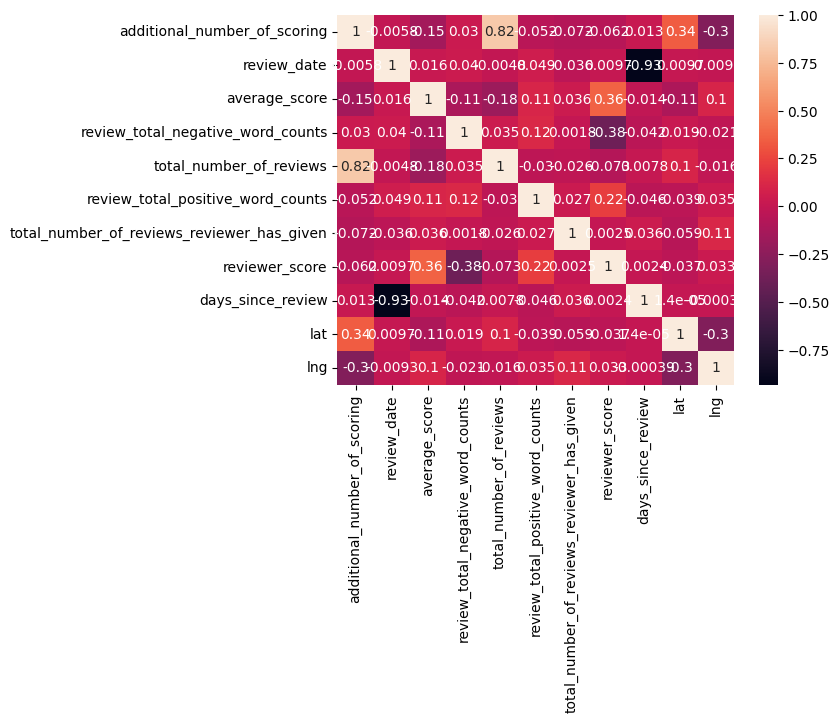

In [62]:
sns.heatmap(hotels.corr(), annot = True)

In [63]:
# удаляем два столбца из за их высокой мультиколл-ти
hotels=hotels.drop(['additional_number_of_scoring','days_since_review'], axis=1)

In [64]:
# список числовых признаков без целевого
num_cols = [s for s in hotels.columns if hotels[s].dtypes != 'object']
num_cols.remove('reviewer_score')
num_cols

['review_date',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng']

<AxesSubplot: >

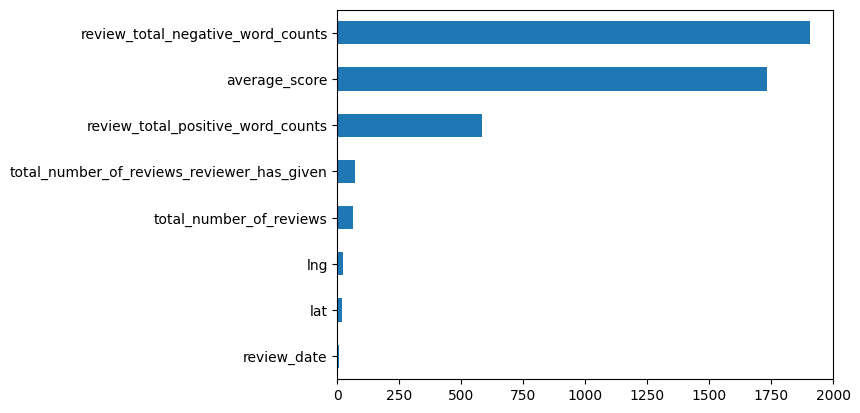

In [65]:
# смотрим важность признака на целевой
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(hotels[num_cols], hotels['reviewer_score'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


In [66]:
# для нормализации, стандартизации
# не стал использовать так как эффект совсем небольшой
#from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
#r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
#df_r = r_scaler.fit_transform(hotels[['review_total_negative_word_counts','review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given']])
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
#col_names = ['review_total_negative_word_counts','review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given']
#df_r = pd.DataFrame(df_r, columns=col_names)
#hotels['review_total_negative_word_counts'] = df_r['review_total_negative_word_counts']
#hotels['review_total_positive_word_counts'] = df_r['review_total_positive_word_counts']
#hotels['total_number_of_reviews_reviewer_has_given'] = df_r['total_number_of_reviews_reviewer_has_given']

In [67]:
hotels.head(2)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,lat,lng,location
0,Stratton Street Mayfair Westminster Borough Lo...,201602,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",51.507894,-0.143671,United Kingdom
1,130 134 Southampton Row Camden London WC1B 5AF...,201701,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",51.521009,-0.123097,United Kingdom


In [68]:
# работаем с признаком tags, переводим в список

def tag_func(tg_n):
    tg_n = tg_n[2:-2]
    res = tg_n.strip().split(' \', \' ')
    return res
hotels['tags_n'] = hotels['tags'].apply(tag_func)
# разобьем таги на столбцы. там где нехватает дополним пробелами.

def exp_l(lst):
    chk = 6 - len(lst)
    while chk>0:
        lst.append('')
        chk-=1
    return lst

hotels.tags_n = hotels.tags_n.apply(exp_l)

In [69]:
# создаем временный датасет для извлечение признаков из признака tags
temp = pd.DataFrame(hotels['tags_n'].to_list(), columns=['t_trip', 't_fam', 't_room', 'n_days', 't_write', 'uknown'])
temp = temp.replace(r'^\s*$', np.nan, regex=True)
temp.head(2)


,t_trip,t_fam,t_room,n_days,t_write,uknown
0,Leisure trip,Couple,Studio Suite,Stayed 2 nights,Submitted from a mobile device,NaN
1,Business trip,Couple,Standard Double Room,Stayed 1 night,NaN,NaN


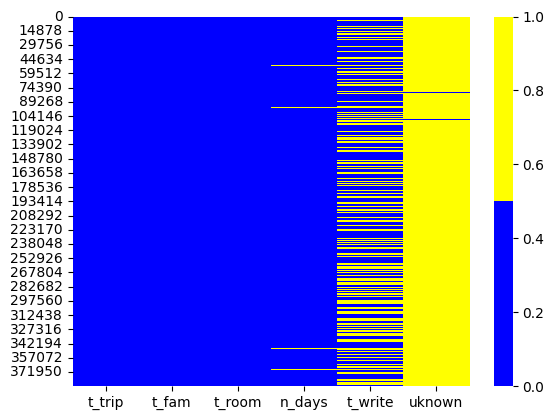

In [70]:
# проверяем наличие пропусков
colors = ['blue', 'yellow'] 
#fig = plt.figure(figsize=(10, 4))
#cols = cols_with_null.index
ax = sns.heatmap(
    temp.isnull(),
    cmap=sns.color_palette(colors),
)

In [71]:
# имеем в ряде строк смещение по столбцам. в признаках перемешаны значения 
print(temp.n_days.value_counts().head(8))
mask = temp['n_days'] == 'Submitted from a mobile device'
temp[mask]


Stayed 1 night                    140089
Stayed 2 nights                    97500
Stayed 3 nights                    70153
Stayed 4 nights                    34789
Stayed 5 nights                    15171
Stayed 6 nights                     7115
Submitted from a mobile device      7083
Stayed 7 nights                     5319
Name: n_days, dtype: int64


,t_trip,t_fam,t_room,n_days,t_write,uknown
31,Family with older children,Luxury Double Room,Stayed 4 nights,Submitted from a mobile device,NaN,NaN
76,Family with young children,Deluxe Twin Room,Stayed 2 nights,Submitted from a mobile device,NaN,NaN
115,Family with young children,Double or Twin Room,Stayed 2 nights,Submitted from a mobile device,NaN,NaN
321,Group,Standard Twin Room,Stayed 1 night,Submitted from a mobile device,NaN,NaN
360,Solo traveler,Standard Single Room,Stayed 1 night,Submitted from a mobile device,NaN,NaN
...,...,...,...,...,...,...
386440,Solo traveler,Standard Double Room,Stayed 3 nights,Submitted from a mobile device,NaN,NaN
386575,Solo traveler,Twin Room,Stayed 1 night,Submitted from a mobile device,NaN,NaN
386580,Couple,Double Room,Stayed 3 nights,Submitted from a mobile device,NaN,NaN
386668,Solo traveler,Standard Double Twin Room,Stayed 2 nights,Submitted from a mobile device,NaN,NaN


In [72]:
# перемещаем значения в проблемном куске 
def chg_val(lst):    
    a, b, c, d = lst['t_trip'], lst['t_fam'], lst['t_room'], lst['n_days']
    lst['t_trip'], lst['t_fam'], lst['t_room'], lst['n_days'] = np.NaN, a, b, c
     
    return lst
temp[mask]=temp[mask].apply(chg_val, axis =1 )

In [73]:
# имеем в ряде строк смещение по столбцам.
mask = temp['uknown'] == 'Submitted from a mobile device'
temp[mask].head(2)

,t_trip,t_fam,t_room,n_days,t_write,uknown
698,With a pet,Leisure trip,Solo traveler,Standard Double Room,Stayed 2 nights,Submitted from a mobile device
1276,With a pet,Leisure trip,Group,Superior Twin Room,Stayed 3 nights,Submitted from a mobile device


In [74]:
# перемещаем значения в проблемном куске 
def chg_val_m(lst):    
    a1, a2, a3, a4 , a5 = lst['t_trip'], lst['t_fam'], lst['t_room'], lst['n_days'], lst['t_write']
    lst['t_trip'], lst['t_fam'], lst['t_room'], lst['n_days'] = a2, a3+' with a pet', a4, a5
     
    return lst

temp[mask]=temp[mask].apply(chg_val_m, axis =1 )

In [75]:
temp.isnull().sum()

t_trip       7083
t_fam           5
t_room         70
n_days       4196
t_write    162785
uknown     386240
dtype: int64

In [76]:
# заменяем пропуски на моду
t1 = temp.t_trip.mode()[0]
t2 = temp.t_fam.mode()[0]
t3 = temp.t_room.mode()[0]
t4 = temp.n_days.mode()[0]
temp['t_trip'] = temp['t_trip'].fillna(value=t1)
temp['t_fam']  = temp.t_fam.fillna (value=t2)
temp['t_room'] = temp.t_room.fillna(value=t3)
temp['n_days'] = temp.n_days.fillna(value=t4)
temp.isnull().sum()

t_trip          0
t_fam           0
t_room          0
n_days          0
t_write    162785
uknown     386240
dtype: int64

In [77]:
temp.nunique()

t_trip        8
t_fam       548
t_room     2351
n_days      178
t_write      14
uknown        1
dtype: int64

In [78]:
# удаляем два столбца t_write, uknown, слишком много NaN, неинформативен, столбец t_fam слишком много уникальных значений 
temp=temp.drop(['t_write', 'uknown', 't_room'], axis=1)

In [79]:
# все что больше семи ночей заменим на others
temp.n_days.value_counts().head(8)

Stayed 1 night     147719
Stayed 2 nights     99187
Stayed 3 nights     71277
Stayed 4 nights     35371
Stayed 5 nights     15443
Stayed 6 nights      7294
Stayed 7 nights      5478
Stayed 8 nights      1876
Name: n_days, dtype: int64

In [80]:
# оптимизируем количество значений в признаках
l1 = ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children']
temp['t_fam'] = temp['t_fam'].apply(lambda x: 'other' if x not in l1 else x)
l2 = ['Leisure trip' , 'Business trip' ] 
temp['t_trip'] = temp['t_trip'].apply(lambda x: 'other' if x not in l2 else x)
l3 = ['Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Stayed 4 nights', 'Stayed 5 nights',
'Stayed 6 nights', 'Stayed 7 nights']
temp['n_days'] = temp['n_days'].apply(lambda x: 'Stayed more then 7 nights' if x not in l3 else x)

In [81]:
# после оптимизации 
temp.nunique()

t_trip    3
t_fam     6
n_days    8
dtype: int64

In [82]:
# для t_fam и t_trip применим OneHotEncoding
temp = pd.get_dummies(temp, columns=['t_fam','t_trip'])

In [83]:
temp.head(2)

,n_days,t_fam_Couple,t_fam_Family with older children,t_fam_Family with young children,t_fam_Group,t_fam_Solo traveler,t_fam_other,t_trip_Business trip,t_trip_Leisure trip,t_trip_other
0,Stayed 2 nights,1,0,0,0,0,0,0,1,0
1,Stayed 1 night,1,0,0,0,0,0,1,0,0


In [84]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
# чем дольше живут в отеле,тем выше вес
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'n_days',
	'mapping': {'Stayed 1 night': 1, 'Stayed 2 nights': 2, 'Stayed 3 nights': 4, 
                'Stayed 4 nights': 8, 'Stayed 5 nights': 16, 'Stayed 6 nights': 32,
                'Stayed 7 nights': 64, 'Stayed more then 7 nights': 128}
}])
# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(temp[['n_days']])
temp=temp.drop(['n_days'], axis=1)


In [85]:
# добавляем закодированные значения
temp = pd.concat([temp, data_bin], axis=1)
temp.head(2)

,t_fam_Couple,t_fam_Family with older children,t_fam_Family with young children,t_fam_Group,t_fam_Solo traveler,t_fam_other,t_trip_Business trip,t_trip_Leisure trip,t_trip_other,n_days
0,1,0,0,0,0,0,0,1,0,2
1,1,0,0,0,0,0,1,0,0,1


In [86]:
temp.isnull().sum()

t_fam_Couple                        0
t_fam_Family with older children    0
t_fam_Family with young children    0
t_fam_Group                         0
t_fam_Solo traveler                 0
t_fam_other                         0
t_trip_Business trip                0
t_trip_Leisure trip                 0
t_trip_other                        0
n_days                              0
dtype: int64

In [87]:
# подправляем некоторые значения в признаках для более правильной работы анализатора слов
hotels['negative_review'].replace('No Negative',' Nothing',inplace=True)
hotels['negative_review'].replace(' N A',' Nothing',inplace=True)
hotels['negative_review'].replace(' None',' Nothing',inplace=True)
hotels['positive_review'].replace('No Positive',' Nothing',inplace=True)
#review = review.replace(['No Negative', 'Nice'],['No Positive', 'Bad'])
#hotels.head(3)

In [88]:
# функция возвращает три значения после анализа предложения.
sent_analyzer = SentimentIntensityAnalyzer()
def extract_value(x):
    out = sent_analyzer.polarity_scores(x)
    return out['neg'],out['neu'],out['pos']


In [89]:
# для негативного ревью вставляем neg, для позитивного pos, нейтральный не используем
hotels['negative_review_set'] = hotels['negative_review'].apply(lambda x: extract_value(x)[0])
hotels['positive_review_set'] = hotels['positive_review'].apply(lambda x: extract_value(x)[2])


In [90]:
# длина ревью как еще один признак для модели
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: len(x))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: len(x))

In [91]:
hotels.shape

(386803, 19)

In [92]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   review_date                                 386803 non-null  int64  
 2   average_score                               386803 non-null  float64
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  int64  
 6   review_total_negative_word_counts           386803 non-null  int64  
 7   total_number_of_reviews                     386803 non-null  int64  
 8   positive_review                             386803 non-null  int64  
 9   review_total_positive_word_counts           386803 non-null  int64  
 

In [96]:
# список категориальных признаков, удаляем из датасета
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
#temp=temp.drop(['t_write', 'uknown', 't_room'], axis=1)
hotels = hotels.drop(object_columns, axis = 1)

In [97]:
hotels.head(2)

,review_date,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,negative_review_set,positive_review_set
0,201602,8.4,9,3,1994,19,4,7,10.0,51.507894,-0.143671,0.000,0.655
1,201701,8.3,15,3,1361,9,2,14,6.3,51.521009,-0.123097,0.756,0.000


In [98]:
# добавили новый датасет с признаками, которые получили ранее к основному
hotels = pd.concat([hotels, temp], axis=1)


In [99]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   negative_review                             386803 non-null  int64  
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   positive_review                             386803 non-null  int64  
 6   review_total_positive_word_counts           386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   reviewer_score                              386803 non-null  float64
 9   lat                                         386803 non-null  float64
 

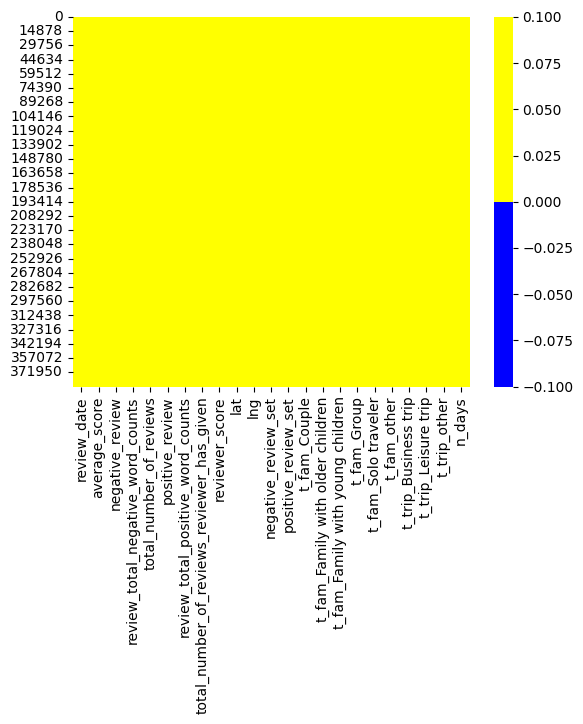

In [100]:
colors = ['blue', 'yellow'] 
ax = sns.heatmap(
    hotels.isnull(),
    cmap=sns.color_palette(colors),
)

In [101]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [102]:
num_cols = [s for s in X.columns if hotels[s].dtypes != 'object']

<AxesSubplot: >

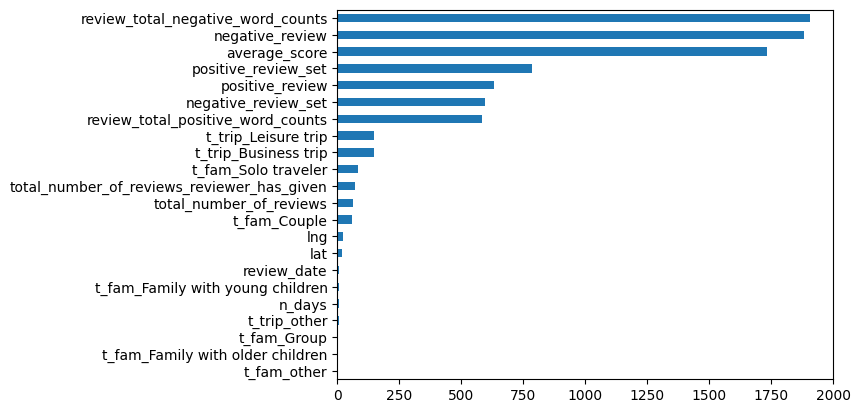

In [103]:
# еще раз смотрим на значимость признаков
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


In [104]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [106]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X[num_cols], y, test_size=0.25, random_state=42)

In [107]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


<AxesSubplot: >

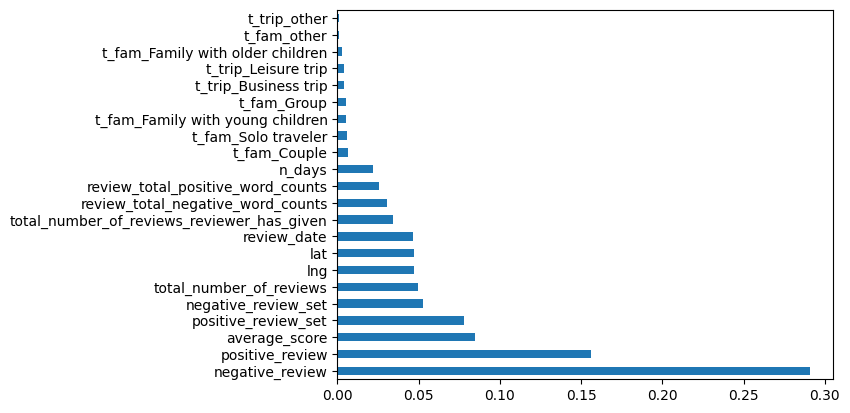

In [109]:
# значимость параметров с точки зрения модели
#plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [110]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12595995152850992
